In [1]:
from src.eda_vector import *
from src.lda_model import *
from src.model import *
from src.classifier import *
from src.helpers import *
from imblearn.over_sampling import SMOTE

In [2]:
'''
NOTE: No EDA appears in this notebook. See Untitled-Copy2 for EDA
--> EDA methods also availible in EDA_vec class
'''
print()

In [3]:
# train, test, split
X_train, X_test, y_train, y_test = get_data(num_samples=1000000, balanced=True)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [4]:
# vectorizing process
custom_stops = ['https', 'rt', 'co', 'amp', 'via', 'go', 'get', 'said', 'say', 'news', 'new', 'make', 'want', 
                'trump', 'clinton', 'donald', 'donald trump', 'donaldtrump', 'says', 'hillary', 'hillaryclinton',
                'hillary clinton', 'realdonaldtrump', 'would', 'let', 'video', 'like']

# custom_stops = ['https', 'rt', 'co', 'amp', 'via', 'go', 'get', 'said', 'say', 'news', 'new', 'make', 'want', 
#                 'says', 'would', 'let', 'video', 'like']

# fit vectorizer, add stop words, return vocab
vectors = EDA_vec(X_train, y_train)
vectors.add_stop_words(custom_stops)
vocab, fit_mat = vectors.vectorize(min_df=0.0001)

# transform traininng and testing data 
matrix = fit_mat.transform(X_train)
matrix_test = fit_mat.transform(X_test)

In [5]:
vectors.legit_count, vectors.troll_count

(375000, 375000)

In [6]:
matrix.shape, matrix_test.shape

((750000, 12504), (250000, 12504))

In [7]:
# fit LDA model on training data
lda = LDA_model(topics=35)
lda.fit(matrix, y_train, vocab)
lda.phi() # to evaluate coherence score
theta = lda.theta()

# get test theta for random forest evaluation
theta_test = lda.test_theta(matrix_test)

PicklingError: Could not pickle the task to send it to the workers.

In [9]:
# random forest parameters
estimators = 150
depth = 150
leafs = None
th_hold = 0.542

In [ ]:
# balance data from LDA theata matrix
# y_smote = y_train
# theta, y_train = SMOTE().fit_resample(theta, y_train)

In [ ]:
# random forest (with LDA)
forest = RandForest(n_estimators=estimators, max_depth=depth, max_leaf=leafs, 
                    max_features=theta.shape[1], class_weight=None)
forest.fit(theta, y_train)
probas, y_hat = forest.predict(theta_test, thresh=th_hold)
forest.score(y_test, y_hat)
print('Random Forest Scores -- with LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

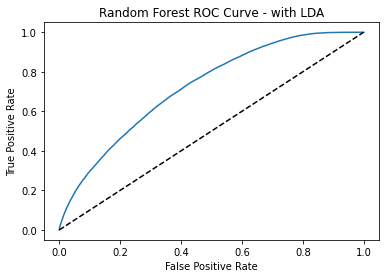

In [11]:
thresh = plot_roc_curve(theta, y_train, lda=True) # with LDA

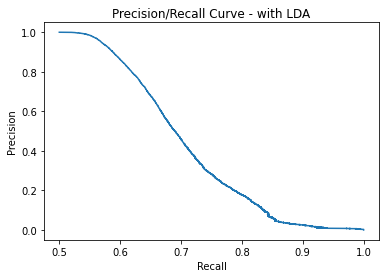

In [13]:
pr_thresh = plot_prec_roc_curve(theta, y_train, lda=True)

In [14]:
# balance data from count vectorized data
# matrix, y_train = SMOTE().fit_resample(matrix, y_smote) # y_smote saved version of y_test before LDA smote changed variable

Random Forest Scores -- w/out LDA
accuracy = 0.590036
oob = 0.753364
recall = 0.181024
precision = 0.9947685409064931
f_one = 0.30630740387283667


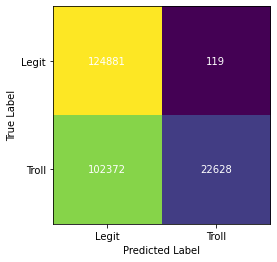

In [27]:
# random forest (without LDA)
forest = RandForest(n_estimators=estimators, max_depth=depth, max_leaf=leafs, 
                    max_features='log2', class_weight=None)
forest.fit(matrix, y_train)
probas, y_hat = forest.predict(matrix_test, thresh=th_hold)
forest.score(y_test, y_hat)
print('Random Forest Scores -- w/out LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

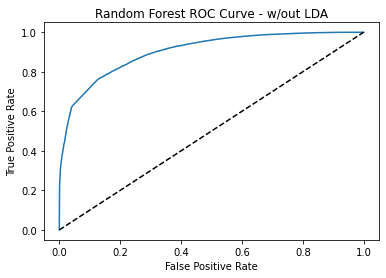

In [11]:
thresh_nolda = plot_roc_curve(matrix, y_train, lda=False) # wihtout LDA

NameError: name 'fpr' is not defined

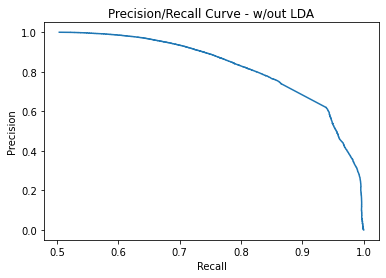

In [13]:
pr_thresh_nolda = plot_prec_roc_curve(matrix, y_train, lda=False)

In [14]:
roc_nums = pd.DataFrame({'fpr': thresh_nolda[0], 'tpr': thresh_nolda[1], 'thresholds': thresh_nolda[2]})

In [39]:
roc_nums[(roc_nums['thresholds'] > .53) & (roc_nums['thresholds'] < .55)]

,fpr,tpr,thresholds
47689,0.028284,0.542133,0.549999
47690,0.028292,0.542133,0.549993
47691,0.028292,0.542140,0.549990
47692,0.028295,0.542140,0.549989
47693,0.028295,0.542144,0.549989
...,...,...,...
69351,0.226080,0.842766,0.530005
69352,0.226080,0.842773,0.530005
69353,0.226094,0.842773,0.530004
69354,0.226094,0.842777,0.530002


In [11]:
lda.display_topics()

Topic 0:
going watch back tax white rally got show campaign much
Topic 1:
election campaign gop win day right president polls voters poll
Topic 2:
time america vote people know khan every way never take
Topic 3:
obama debate man women bill presidential debatenight vote still speech
Topic 4:
us president cnn think even taxes family know lies people


In [16]:
lda.coherance_score()

-5.237078828221568

In [31]:
lda.coherance_score()

-4.748669717009582

In [ ]:
'''TOPIC COHERANCE SCORES: --> only 10k data samples'''
# topics 2 --> -7.487219089117191
# topics 4 --> -10.222697013007569
# topics 6 --> -12.070494413320219
# topics 8 --> -13.165411752758045
# topics 10 --> -13.466351137344793
# topics 12 --> -14.279565234962526
# topics 14 --> -14.610241988703596
# topics 18 --> -15.333867297657738
# topics 20 --> -15.802765426002347
# topics 22 --> -15.90626134524627
# topics 24 --> -16.21720655745143
# topics 26 --> -15.494214848919107

In [17]:
# test for best num_topics:

def test_topics(X, y, vocab, low, high, by):
    scores = []
    
    for n_topic in range(low, high, by):
        lda = LDA_model(topics=n_topic)
        lda.fit(X, y, vocab)
        lda.phi()
        score = lda.coherance_score()
        scores.append((n_topic, score))
        
    return scores

def print_topic_score(scores):
    for score in scores:
        print(f'#{score[0]} --> {score[1]}')
        
def plot_topic_scores(scores):
    fig, ax = plt.subplots()
    x = [n_topics[0] for n_topics in scores]
    y = [score[1] for score in scores]
    
    ax.plot(x, y)
    ax.set_title('Coherence Score by Topic')
    ax.set_xlabel('# of Topics')
    ax.set_ylabel('Coherence Score');

In [ ]:
topic_scores = test_topics(matrix, y_train, vocab, 2, 30, 2)

In [ ]:
print_topic_scores(topic_scores)

In [ ]:
plot_topic_scores(topic_scores)

In [89]:
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, plot_confusion_matrix

# Random Forest, X = theta, y = y_train
def eval_random_forest(X, y, folds=15, n_estimators=500, max_depth=15, max_leaf=None):
    
    kf = KFold(n_splits=folds, shuffle=True)
    accur = []
    oob_  = []
    rec   = []
    prec  = []
    f_1   = []
    iters = 0
    
    for train, test in kf.split(X):
        
        # random forest 
        forest = RandForest(n_estimators=n_estimators, max_depth=max_depth, 
                            max_leaf=max_leaf, max_features=theta.shape[1])
        forest.fit(X[train], y.iloc[train])
        probas, y_hat = forest.predict(X[test])
        forest.score(y.iloc[test], y_hat)
        
        accur.append(forest.acc)
        oob_.append(forest.oob)
        rec.append(forest.recall)
        prec.append(forest.precision)
        f_1.append(forest.f_one)
        
        iters += 1
        if iters % 5 == 0:
            print(iters)
        
    
    return np.mean(accur), np.mean(oob_), np.mean(rec), np.mean(prec), np.mean(f_1), forest

In [90]:
accuracy, mean, rec, prec, model = eval_random_forest(theta, y_train)

5
10
15


In [29]:
'''
Evaluate best number of estimators, leafs, and max_depth
'''
# Parameter testing
def test_forest_depth(X, y, depth_lst, th_hold=.5, max_features='log2', lda=False):
    accur = []
    oob_  = []
    rec   = []
    prec  = []
    f_1   = []

    for depth in depth_lst:
        forest = RandForest(n_estimators=500, max_depth=depth, max_leaf=100, 
                            max_features=max_features, class_weight=None)
        forest.fit(X, y)
        probas, y_hat = forest.predict(matrix_test, thresh=th_hold)
        forest.score(y_test, y_hat)
        accur.append(forest.acc)
        oob_.append(forest.oob)
        rec.append(forest.recall)
        prec.append(forest.precision)
        f_1.append(forest.f_one)
        
        if lda:
            print('Random Forest Scores -- w/ LDA')
        else:
            print('Random Forest Scores -- w/out LDA')

        print(f'Depth = {depth}')
        print(f'accuracy = {forest.acc}')
        print(f'oob = {forest.oob}')
        print(f'recall = {forest.recall}')
        print(f'precision = {forest.precision}')
        print(f'f_1 score = {forest.f_one}')
        print('-----------------')
    
    return [accur, oob_, rec, prec, f_1]

def test_forest_estimators(X, y, est_lst, th_hold=.5, max_features='log2', lda=False):
    accur = []
    oob_  = []
    rec   = []
    prec  = []
    f_1   = []

    for est in est_lst:
        forest = RandForest(n_estimators=est, max_depth=100, max_leaf=100, 
                            max_features=max_features, class_weight=None)
        forest.fit(X, y)
        probas, y_hat = forest.predict(matrix_test, thresh=th_hold)
        forest.score(y_test, y_hat)
        accur.append(forest.acc)
        oob_.append(forest.oob)
        rec.append(forest.recall)
        prec.append(forest.precision)
        f_1.append(forest.f_one)
        
        if lda:
            print('Random Forest Scores -- w/ LDA')
        else:
            print('Random Forest Scores -- w/out LDA')

        print(f'Estimators = {est}')
        print(f'accuracy = {forest.acc}')
        print(f'oob = {forest.oob}')
        print(f'recall = {forest.recall}')
        print(f'precision = {forest.precision}')
        print(f'f_1 score = {forest.f_one}')
        print('-----------------')
    
    return [accur, oob_, rec, prec, f_1]


In [38]:
depth_lst = [150, 200, 250, 300]
depth_score = test_forest_depth(matrix, y_train, depth_lst, th_hold=.542, max_features='log2', lda=False)

Random Forest Scores -- w/out LDA
Depth = 150
accuracy = 0.745068
oob = 0.7532626666666666
recall = 0.537896
precision = 0.9184504214077889
f_1 score = 0.6784523250944718
-----------------
Random Forest Scores -- w/out LDA
Depth = 200
accuracy = 0.739188
oob = 0.753304
recall = 0.521584
precision = 0.9234974999645887
f_1 score = 0.6666496249980828
-----------------
Random Forest Scores -- w/out LDA
Depth = 250
accuracy = 0.740968
oob = 0.7533693333333333
recall = 0.527256
precision = 0.9208489353378416
f_1 score = 0.6705634576643672
-----------------
Random Forest Scores -- w/out LDA
Depth = 300
accuracy = 0.741976
oob = 0.7542906666666667
recall = 0.529264
precision = 0.9211383698588176
f_1 score = 0.6722622471065226
-----------------


In [41]:
est_lst = [100, 150, 200, 250]
scores = test_forest_estimators(matrix, y_train, est_lst, th_hold=.542, max_features='log2', lda=False)

Random Forest Scores -- w/out LDA
Estimators = 100
accuracy = 0.739008
oob = 0.7530293333333333
recall = 0.524608
precision = 0.9184313725490196
f_1 score = 0.6677800407331975
-----------------
Random Forest Scores -- w/out LDA
Estimators = 150
accuracy = 0.77486
oob = 0.751732
recall = 0.726184
precision = 0.8045040813251677
f_1 score = 0.7633403551261189
-----------------
Random Forest Scores -- w/out LDA
Estimators = 200
accuracy = 0.741012
oob = 0.7527346666666667
recall = 0.527216
precision = 0.9210493214630124
f_1 score = 0.6705842249594254
-----------------
Random Forest Scores -- w/out LDA
Estimators = 250
accuracy = 0.740424
oob = 0.754044
recall = 0.52552
precision = 0.9216544602519853
f_1 score = 0.669370369992969
-----------------


In [34]:
def plot_eval_scores(scores, metric_lst, metric):
    fig, ax = plt.subplots(figsize=(8,5))
    x = metric_lst
    
    ax.plot(x, [score for score in scores[0]], label='Accuracy')
    ax.plot(x, [score for score in scores[1]], label='OOB')
    ax.plot(x, [score for score in scores[2]], label='Recall')
    ax.plot(x, [score for score in scores[3]], label='Precision')
    ax.plot(x, [score for score in scores[4]], label='F_One')
    
    ax.set_title(f'Evaluation Scores {metric}')
    ax.set_xlabel(f'Number of {metric}')
    ax.set_ylabel(f'Score')
    ax.legend();

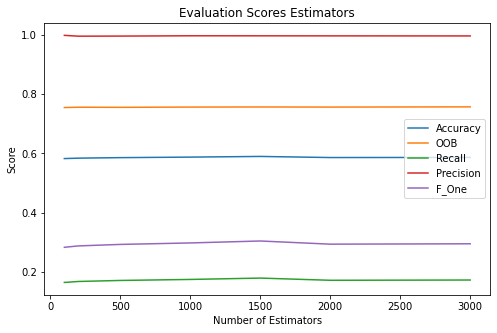

In [40]:
plot_eval_scores(scores, est_lst, 'Estimators') # .5 threshold, class_weight = balanced

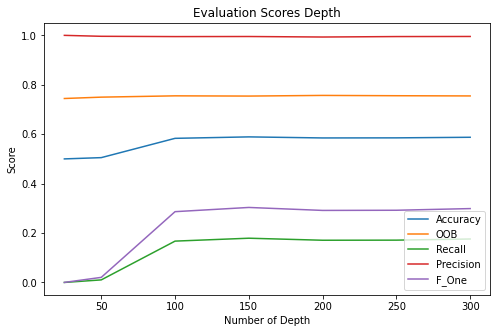

In [41]:
plot_eval_scores(depth_score, depth_lst, 'Depth') # .5 threshold, class_weight = balanced

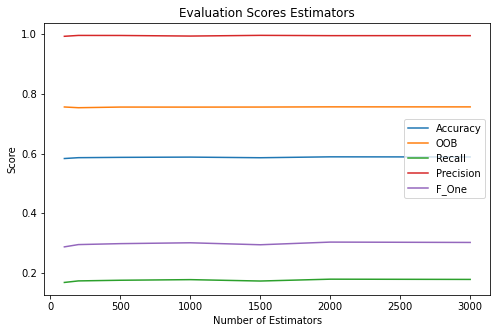

In [51]:
plot_eval_scores(scores, est_lst, 'Estimators') # .75 threshold, class_weight = None

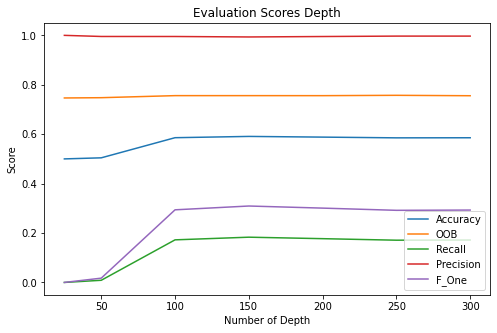

In [52]:
plot_eval_scores(depth_score, depth_lst, 'Depth') # .75 threshold, class_weight = None

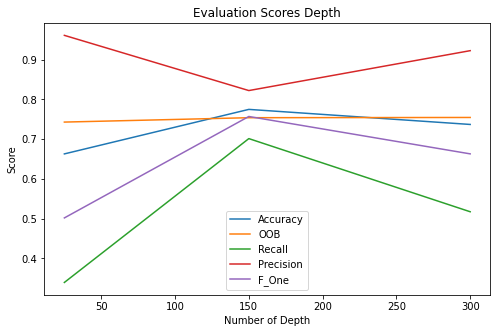

In [35]:
plot_eval_scores(depth_score, depth_lst, 'Depth') #.521

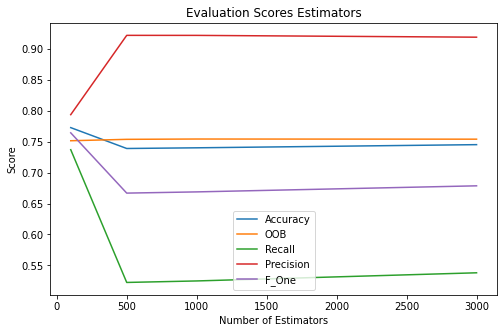

In [37]:
plot_eval_scores(scores, est_lst, 'Estimators')

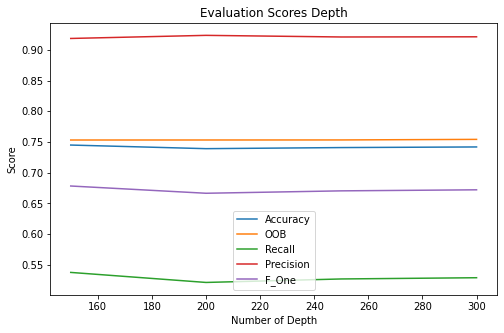

In [40]:
plot_eval_scores(depth_score, depth_lst, 'Depth')

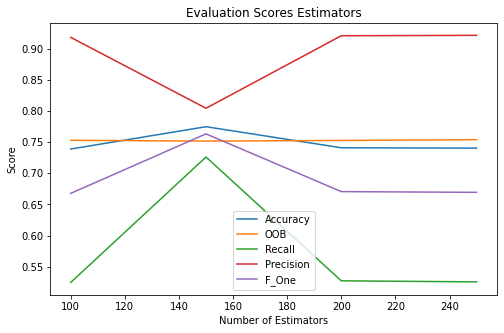

In [42]:
plot_eval_scores(scores, est_lst, 'Estimators')

In [28]:
lst = [score for score in scores[0]]

In [29]:
lst

[0.58246, 0.58386, 0.5856, 0.58738, 0.58964, 0.58594, 0.58636]